# Portfolio Selection Optimization
This model is an example of the classic [Markowitz portfolio selection optimization model](https://en.wikipedia.org/wiki/Markowitz_model). We want to find the fraction of the portfolio to invest among a set of stocks that balances risk and return. It is a Quadratic Programming (QP) model with vector and matrix data for returns and risk, respectively. This is best suited to a matrix formulation, so we use the Gurobi Python *matrix* interface.

## Model Formulation
### Parameters

We use the [Greek values](https://en.wikipedia.org/wiki/Greeks_\(finance\)) that are traditional in finance:

- $\delta$: n-element vector measuring the change in price for each stock
- $\sigma$: n x n matrix measuring the covariance among stocks

There is one additional parameter when solving the model parametrically:

- r: target return


### Decision Variables
- $x \ge 0$: n-element vector where each element represents the fraction of the porfolio to invest in each stock

### Objective Function
Minimize the total risk, a convex quadratic function:

\begin{equation}
\min x^t \cdot \sigma \cdot x
\end{equation}

### Constraints

Allocate the entire portfolio: the total investments should be 1.0 (100%), where $e$ is a unit vector (all 1's):

\begin{equation}
e \cdot x = 1
\end{equation}


Return: When we solve the model parametrically for different return values $r$, we add a constraint on the target return:

\begin{equation}
\delta \cdot x = r
\end{equation}

## Python Implementation
### Stock data
Use [yfinance](https://pypi.org/project/yfinance/) library to get the latest 2 years of _actual stock data_ from the 20 most profitable US companies, [according to Wikipedia in April 2021](https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue#List_of_companies_by_profit).

In [354]:
%pip install gurobipy scipy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [355]:
%matplotlib inline

In [356]:
import pandas as pd

labels1 = [ 'stocks', 'bonds', 'money_market' ]
data1 = pd.DataFrame([
  { 'year': 1960, 'stocks': 20.2553, 'bonds': 262.935, 'money_market': 100.00},
  { 'year': 1961, 'stocks': 25.6860, 'bonds': 268.730, 'money_market': 102.33},
  { 'year': 1962, 'stocks': 23.4297, 'bonds': 284.090, 'money_market': 105.33},
  { 'year': 1963, 'stocks': 28.7463, 'bonds': 289.162, 'money_market': 108.89},
  { 'year': 1964, 'stocks': 33.4484, 'bonds': 299.894, 'money_market': 113.08},
  { 'year': 1965, 'stocks': 37.5813, 'bonds': 302.695, 'money_market': 117.97},
  { 'year': 1966, 'stocks': 33.7839, 'bonds': 318.197, 'money_market': 124.34},
  { 'year': 1967, 'stocks': 41.8725, 'bonds': 309.103, 'money_market': 129.94},
  { 'year': 1968, 'stocks': 46.4795, 'bonds': 316.051, 'money_market': 137.77},
  { 'year': 1969, 'stocks': 42.5448, 'bonds': 298.249, 'money_market': 150.12},
  { 'year': 1970, 'stocks': 44.2212, 'bonds': 354.671, 'money_market': 157.48},
  { 'year': 1971, 'stocks': 50.5451, 'bonds': 394.532, 'money_market': 164.00},
  { 'year': 1972, 'stocks': 60.1461, 'bonds': 403.942, 'money_market': 172.74},
  { 'year': 1973, 'stocks': 51.3114, 'bonds': 417.252, 'money_market': 189.93},
  { 'year': 1974, 'stocks': 37.7306, 'bonds': 433.927, 'money_market': 206.13},
  { 'year': 1975, 'stocks': 51.7772, 'bonds': 457.885, 'money_market': 216.85},
  { 'year': 1976, 'stocks': 64.1659, 'bonds': 529.141, 'money_market': 226.93},
  { 'year': 1977, 'stocks': 59.5739, 'bonds': 531.144, 'money_market': 241.82},
  { 'year': 1978, 'stocks': 63.4884, 'bonds': 524.435, 'money_market': 266.07},
  { 'year': 1979, 'stocks': 75.3032, 'bonds': 531.040, 'money_market': 302.74},
  { 'year': 1980, 'stocks': 99.7795, 'bonds': 517.860, 'money_market': 359.96},
  { 'year': 1981, 'stocks': 94.8671, 'bonds': 538.769, 'money_market': 404.48},
  { 'year': 1982, 'stocks': 115.308, 'bonds': 777.332, 'money_market': 440.68},
  { 'year': 1983, 'stocks': 141.316, 'bonds': 787.357, 'money_market': 482.42},
  { 'year': 1984, 'stocks': 150.181, 'bonds': 907.712, 'money_market': 522.84},
  { 'year': 1985, 'stocks': 197.829, 'bonds': 1200.63, 'money_market': 566.08},
  { 'year': 1986, 'stocks': 234.755, 'bonds': 1469.45, 'money_market': 605.20},
  { 'year': 1987, 'stocks': 247.080, 'bonds': 1424.91, 'money_market': 646.17},
  { 'year': 1988, 'stocks': 288.116, 'bonds': 1522.40, 'money_market': 702.77},
  { 'year': 1989, 'stocks': 379.409, 'bonds': 1804.63, 'money_market': 762.16},
  { 'year': 1990, 'stocks': 367.636, 'bonds': 1944.25, 'money_market': 817.87},
  { 'year': 1991, 'stocks': 479.633, 'bonds': 2320.64, 'money_market': 854.10},
  { 'year': 1992, 'stocks': 516.178, 'bonds': 2490.97, 'money_market': 879.04},
  { 'year': 1993, 'stocks': 568.202, 'bonds': 2816.40, 'money_market': 905.06},
  { 'year': 1994, 'stocks': 575.705, 'bonds': 2610.12, 'money_market': 954.39},
  { 'year': 1995, 'stocks': 792.042, 'bonds': 3287.27, 'money_market': 1007.84},
  { 'year': 1996, 'stocks': 973.897, 'bonds': 3291.58, 'money_market': 1061.15},
  { 'year': 1997, 'stocks': 1298.82, 'bonds': 3687.33, 'money_market': 1119.51},
  { 'year': 1998, 'stocks': 1670.01, 'bonds': 4220.24, 'money_market': 1171.91},
  { 'year': 1999, 'stocks': 2021.40, 'bonds': 3903.32, 'money_market': 1234.02},
  { 'year': 2000, 'stocks': 1837.36, 'bonds': 4575.33, 'money_market': 1313.00},
  { 'year': 2001, 'stocks': 1618.98, 'bonds': 4827.26, 'money_market': 1336.89},
  { 'year': 2002, 'stocks': 1261.18, 'bonds': 5558.40, 'money_market': 1353.47},
  { 'year': 2003, 'stocks': 1622.94, 'bonds': 5588.19, 'money_market': 1366.73},
])

labels2 = [ 'stocks', 'bonds', 'money_market', 'NASDAQ' ]
data2 = pd.DataFrame([
  { 'year': 1960, 'stocks': 20.2553, 'bonds': 262.935, 'money_market': 100.00, 'NASDAQ': 34.461 },
  { 'year': 1961, 'stocks': 25.6860, 'bonds': 268.730, 'money_market': 102.33, 'NASDAQ': 45.373 },
  { 'year': 1962, 'stocks': 23.4297, 'bonds': 284.090, 'money_market': 105.33, 'NASDAQ': 38.556 },
  { 'year': 1963, 'stocks': 28.7463, 'bonds': 289.162, 'money_market': 108.89, 'NASDAQ': 46.439 },
  { 'year': 1964, 'stocks': 33.4484, 'bonds': 299.894, 'money_market': 113.08, 'NASDAQ': 57.175 },
  { 'year': 1965, 'stocks': 37.5813, 'bonds': 302.695, 'money_market': 117.97, 'NASDAQ': 66.982 },
  { 'year': 1966, 'stocks': 33.7839, 'bonds': 318.197, 'money_market': 124.34, 'NASDAQ': 63.934 },
  { 'year': 1967, 'stocks': 41.8725, 'bonds': 309.103, 'money_market': 129.94, 'NASDAQ': 80.935 },
  { 'year': 1968, 'stocks': 46.4795, 'bonds': 316.051, 'money_market': 137.77, 'NASDAQ': 101.79 },
  { 'year': 1969, 'stocks': 42.5448, 'bonds': 298.249, 'money_market': 150.12, 'NASDAQ': 99.389 },
  { 'year': 1970, 'stocks': 44.2212, 'bonds': 354.671, 'money_market': 157.48, 'NASDAQ': 89.607 },
  { 'year': 1971, 'stocks': 50.5451, 'bonds': 394.532, 'money_market': 164.00, 'NASDAQ': 114.12 },
  { 'year': 1972, 'stocks': 60.1461, 'bonds': 403.942, 'money_market': 172.74, 'NASDAQ': 133.73 },
  { 'year': 1973, 'stocks': 51.3114, 'bonds': 417.252, 'money_market': 189.93, 'NASDAQ': 92.190 },
  { 'year': 1974, 'stocks': 37.7306, 'bonds': 433.927, 'money_market': 206.13, 'NASDAQ': 59.820 },
  { 'year': 1975, 'stocks': 51.7772, 'bonds': 457.885, 'money_market': 216.85, 'NASDAQ': 77.620 },
  { 'year': 1976, 'stocks': 64.1659, 'bonds': 529.141, 'money_market': 226.93, 'NASDAQ': 97.880 },
  { 'year': 1977, 'stocks': 59.5739, 'bonds': 531.144, 'money_market': 241.82, 'NASDAQ': 105.05 },
  { 'year': 1978, 'stocks': 63.4884, 'bonds': 524.435, 'money_market': 266.07, 'NASDAQ': 117.98 },
  { 'year': 1979, 'stocks': 75.3032, 'bonds': 531.040, 'money_market': 302.74, 'NASDAQ': 151.14 },
  { 'year': 1980, 'stocks': 99.7795, 'bonds': 517.860, 'money_market': 359.96, 'NASDAQ': 202.34 },
  { 'year': 1981, 'stocks': 94.8671, 'bonds': 538.769, 'money_market': 404.48, 'NASDAQ': 195.84 },
  { 'year': 1982, 'stocks': 115.308, 'bonds': 777.332, 'money_market': 440.68, 'NASDAQ': 232.41 },
  { 'year': 1983, 'stocks': 141.316, 'bonds': 787.357, 'money_market': 482.42, 'NASDAQ': 278.60 },
  { 'year': 1984, 'stocks': 150.181, 'bonds': 907.712, 'money_market': 522.84, 'NASDAQ': 247.35 },
  { 'year': 1985, 'stocks': 197.829, 'bonds': 1200.63, 'money_market': 566.08, 'NASDAQ': 324.39 },
  { 'year': 1986, 'stocks': 234.755, 'bonds': 1469.45, 'money_market': 605.20, 'NASDAQ': 348.81 },
  { 'year': 1987, 'stocks': 247.080, 'bonds': 1424.91, 'money_market': 646.17, 'NASDAQ': 330.47 },
  { 'year': 1988, 'stocks': 288.116, 'bonds': 1522.40, 'money_market': 702.77, 'NASDAQ': 381.38 },
  { 'year': 1989, 'stocks': 379.409, 'bonds': 1804.63, 'money_market': 762.16, 'NASDAQ': 454.82 },
  { 'year': 1990, 'stocks': 367.636, 'bonds': 1944.25, 'money_market': 817.87, 'NASDAQ': 373.84 },
  { 'year': 1991, 'stocks': 479.633, 'bonds': 2320.64, 'money_market': 854.10, 'NASDAQ': 586.34 },
  { 'year': 1992, 'stocks': 516.178, 'bonds': 2490.97, 'money_market': 879.04, 'NASDAQ': 676.95 },
  { 'year': 1993, 'stocks': 568.202, 'bonds': 2816.40, 'money_market': 905.06, 'NASDAQ': 776.80 },
  { 'year': 1994, 'stocks': 575.705, 'bonds': 2610.12, 'money_market': 954.39, 'NASDAQ': 751.96 },
  { 'year': 1995, 'stocks': 792.042, 'bonds': 3287.27, 'money_market': 1007.84, 'NASDAQ': 1052.1 },
  { 'year': 1996, 'stocks': 973.897, 'bonds': 3291.58, 'money_market': 1061.15, 'NASDAQ': 1291.0 },
  { 'year': 1997, 'stocks': 1298.82, 'bonds': 3687.33, 'money_market': 1119.51, 'NASDAQ': 1570.3 },
  { 'year': 1998, 'stocks': 1670.01, 'bonds': 4220.24, 'money_market': 1171.91, 'NASDAQ': 2192.7 },
  { 'year': 1999, 'stocks': 2021.40, 'bonds': 3903.32, 'money_market': 1234.02, 'NASDAQ': 4069.3 },
  { 'year': 2000, 'stocks': 1837.36, 'bonds': 4575.33, 'money_market': 1313.00, 'NASDAQ': 2470.5 },
  { 'year': 2001, 'stocks': 1618.98, 'bonds': 4827.26, 'money_market': 1336.89, 'NASDAQ': 1950.4 },
  { 'year': 2002, 'stocks': 1261.18, 'bonds': 5558.40, 'money_market': 1353.47, 'NASDAQ': 1335.5 },
  { 'year': 2003, 'stocks': 1622.94, 'bonds': 5588.19, 'money_market': 1366.73, 'NASDAQ': 2003.4 },
])

In [357]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from math import sqrt
import matplotlib.pyplot as plt

class MarkowitzModel:
  def __init__(self, input_data):
    self.set_data(input_data)
  
  def set_data(self, input_data):
    self.data = input_data
    self.labels = list(self.data.columns[1:])

  def get_mean_gmean_volatility(self):
    """
    Prints the mean, the geometric mean and the volatility of each asset.
    """
    self._compute_parameters()
  
    df = pd.DataFrame(
      data=np.array([self.mean, self.gmean, self.volatility]),
      index=['mean', 'gmean', 'volatility'],
      columns=self.labels
    )

    return df

  def solve(self, targets=None, enable_gurobi_output=False, use_geometric_mean=True):
    """
    Solve the model and return the portfolios that have been computed in the following format:
      ( volatility, return, [ array of % for each asset ] ) if there is a solution
      ()                                                    if the model cannot be solved

    Params:
     - targets: the return targets we want to run the model with. They will be used as constraints. None means optimize for lowest volatility.
     - enable_gurobi_output: if true the gurobi solver will print all the outputs during processing. Defaults to False.
     - use_geometric_mean: decide whether to consider geometric or arithmetic mean to compute the expected return of the portfolio. Defaults to True. 
    """
    self._compute_parameters()
    self._init_model(enable_gurobi_output, use_geometric_mean)

    if targets is None:
      return [ self._solve(use_geometric_mean) ]

    portfolios = []
    for target in targets:
      self._add_return_constraint(target, use_geometric_mean)
      portfolios.append(self._solve(use_geometric_mean))

    return portfolios

  def _init_model(self, enable_gurobi_output, use_geometric_mean):
    """
    Init the model with the params.
    Does not set the target constraint, see `self._add_return_contraint` for that.
    """
    self.model = gp.Model('portfolio')
    self.model.setParam('OutputFlag', 1 if enable_gurobi_output else 0)
    self.x = self.model.addMVar(len(self.labels))

    self.portfolio_risk = self.x @ self.sigma @ self.x
    self.model.setObjective(self.portfolio_risk, GRB.MINIMIZE)

    self.model.addConstr(self.x.sum() == 1, 'budget')
    self.expected_return_constraint = None

    self.model.write('portfolio_selection_optimization.lp')

  def _add_return_constraint(self, target, use_geometric_mean):
    """
    Set the return target constraint. Tries to edit a previous constraint,
    the solver is optimized to compute only the values needed after the change. 
    """
    if self.expected_return_constraint is None:
      expected_return_expr = self.gmean @ self.x if use_geometric_mean else self.mean @ self.x
      self.expected_return_constraint = self.model.addConstr(expected_return_expr == target, 'target')
    else:
      self.expected_return_constraint.rhs = target

  def _solve(self, use_geometric_mean):
    """
    Return the portfolio after solving the model.
    """
    self.model.optimize()
    
    if self.model.status != GRB.OPTIMAL:
      return ()
    
    expected_avg_return = self.gmean if use_geometric_mean else self.mean
    portfolio_volatility = self.model.ObjVal
    portfolio_return = expected_avg_return @ self.x.X
    return (portfolio_return, portfolio_volatility, self.x.X)

  def _compute_parameters(self):
    """
    Compute all the parameters used by the model and some extra parameters that
    might be usefull to understand whats happening.
    """

    n = len(self.labels)
    self.values = np.array([self.data[l] for l in self.labels])
    self.absdiff = np.diff(self.values)                                                                 # price difference year on year
    self.reldiff = np.divide(self.absdiff, self.values[:,:-1])                                          # relative price difference year on year
    self.mean = np.mean(self.reldiff, axis=1)                                                           # mean price change
    self.gmean = np.array([self._compute_geometric_mean_for_asset(self.reldiff[i]) for i in range(n)])  # geometric mean
    self.sigma = np.cov(self.reldiff)                                                                   # covariance matrix
    self.std = np.std(self.reldiff, axis=1)                                                             # standard deviation
    self.volatility = np.array([sqrt(self.sigma[i][i]) for i in range(len(self.sigma[0]))])             # volatility
    self.correlation = np.matrix([[self.sigma[i][j] / (self.volatility[i] * self.volatility[j]) for j in range(n)] for i in range(n)])

  def _compute_geometric_mean_for_asset(self, reldiff):
    tmp = [ i + 1 for i in reldiff ]
    accumulator = 1
    for i in tmp:
      accumulator *= i
    return accumulator ** (1.0 / len(tmp)) - 1


# -------------------- Utilities ---------------------------

def portfolios_to_dataframe(portfolios, labels):
  return pd.DataFrame(
    data=np.array([[p[0], p[1], *p[2]] for p in portfolios]),
    columns=['return', 'volatility', *labels],
  )

def plot_portfolio(df, labels):
  # Create a figure with two subplots
  fig, axs = plt.subplots(1, 2, figsize=(14, 6))

  # Left plot: return vs. volatility
  axs[0].plot(df['return'], df['volatility'])
  axs[0].set_xlabel('Return')
  axs[0].set_ylabel('Volatility')
  axs[0].set_title('Return vs. Volatility')

  # Right plot: asset allocation
  axs[1].stackplot(df['return'], *[ df[l] for l in labels ], labels=labels)
  axs[1].set_xlabel('Return')
  axs[1].set_ylabel('Percentage')
  axs[1].set_title('Asset Allocation')
  axs[1].legend(loc='lower right')

  # Show the plot
  plt.show()

# Example 1

In this example we will use the data from `data1` containing the following assets:
- Stocks (S&P 500)
- Bonds (10-year Treasury Bonds Index)
- Money Market

We will first solve the model with no particular target return, hence we will get the lowest volatility portfolio possible.

We will also plot some data about the assets:
- `mean`: arithmetic mean of relative difference for the asset price year on year [0, 1]
- `gmean`: similar to `mean` but uses the geometric mean
- `volatility`: how much the asset value has fluctuated in the time span considered

Ideally we will expect portfolios with lower return targets to heavily invest on bonds and cash since since they usually have a lower volatility but in order to get higher returns the stock percentage will have to grow substantially.

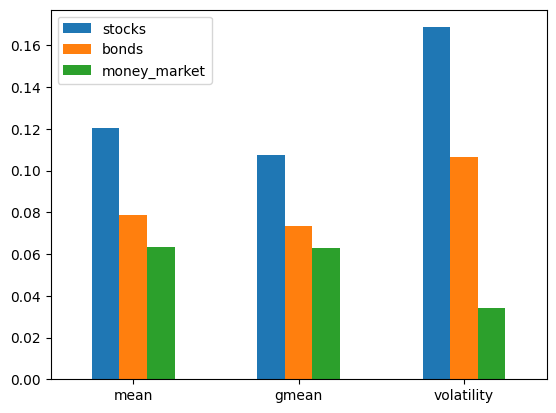

In [358]:
model = MarkowitzModel(data1)
result = model.solve()
portfolios_to_dataframe(result, labels1)

ax = model.get_mean_gmean_volatility().plot.bar(rot=0)
plt.show()

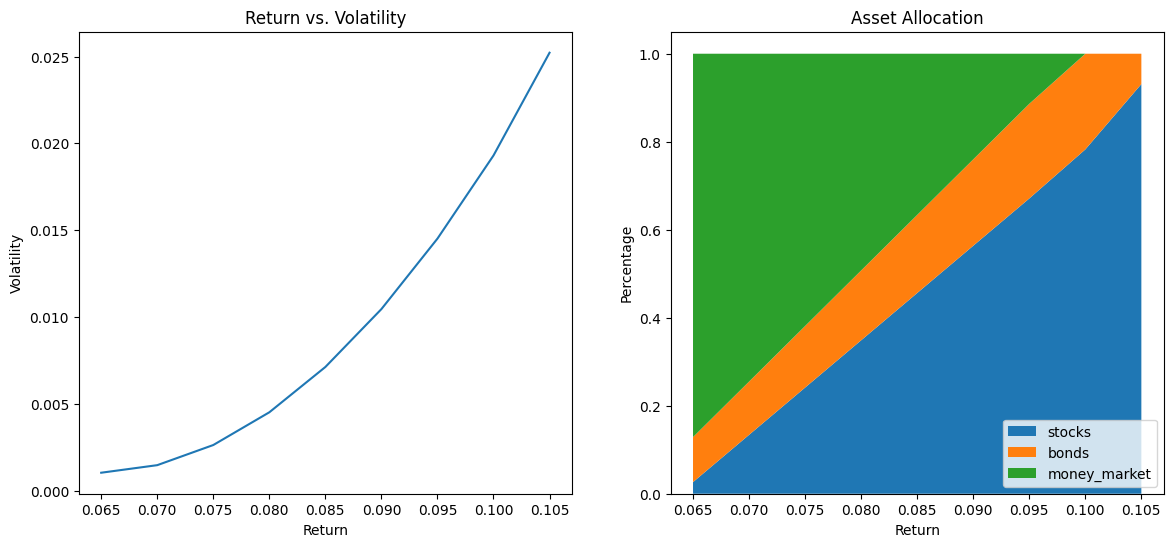

,return,volatility,stocks,bonds,money_market
0,0.065,0.001031,0.026382,0.102259,8.713591e-01
1,0.070,0.001467,0.133814,0.121077,7.451083e-01
2,0.075,0.002627,0.241247,0.139894,6.188591e-01
3,0.080,0.004511,0.348680,0.158711,4.926088e-01
4,0.085,0.007121,0.456113,0.177526,3.663604e-01
5,0.090,0.010455,0.563546,0.196342,2.401114e-01
6,0.095,0.014513,0.670979,0.215159,1.138622e-01
7,0.100,0.019300,0.782449,0.217551,2.611459e-08
8,0.105,0.025218,0.931027,0.068973,1.631196e-09


In [359]:
model = MarkowitzModel(data1)
portfolios = model.solve(targets=np.arange(0.065, 0.110, 0.005))
df = portfolios_to_dataframe(portfolios, labels1)
plot_portfolio(df, labels1)

df

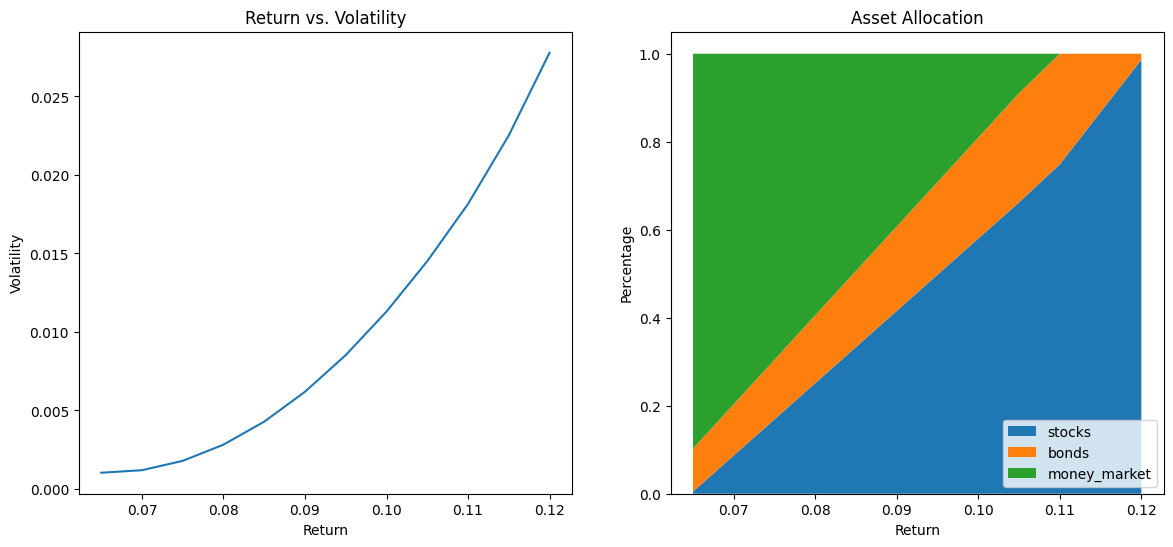

,return,volatility,stocks,bonds,money_market
0,0.065,0.001031,0.004787,0.097904,8.973091e-01
1,0.070,0.001192,0.086984,0.116682,7.963339e-01
2,0.075,0.001788,0.169182,0.135459,6.953589e-01
3,0.080,0.002819,0.251379,0.154237,5.943838e-01
4,0.085,0.004286,0.333576,0.173016,4.934080e-01
5,0.090,0.006188,0.415774,0.191793,3.924335e-01
6,0.095,0.008525,0.497971,0.210571,2.914585e-01
7,0.100,0.011298,0.580168,0.229349,1.904831e-01
8,0.105,0.014507,0.662366,0.248125,8.950896e-02
9,0.110,0.018153,0.748726,0.251274,1.787139e-07


In [360]:
model = MarkowitzModel(data1)
portfolios = model.solve(targets=np.arange(0.065, 0.125, 0.005), use_geometric_mean=False)
df = portfolios_to_dataframe(portfolios, labels1)
plot_portfolio(df, labels1)

df

# Example 2

In this example we will use the data from `data2` containing the following assets:
- Stocks (S&P 500)
- Bonds (10-year Treasury Bonds Index)
- Money Market
- NASDAQ Composite Index

We will first solve the model with no particular target return, hence we will get the lowest volatility portfolio possible.

We will also plot some data about the assets:
- `mean`: arithmetic mean of relative difference for the asset price year on year [0, 1]
- `gmean`: similar to `mean` but uses the geometric mean
- `volatility`: how much the asset value has fluctuated in the time span considered

I initially expected to see big investments on the NASDAQ for higher returns portfolios but I've been proved wrong by the model.

An interpretation I have about the following data is that as we can see NASDAQ does not yield better results than stocks for `gmean` and its slightly better on `mean` (infact the model that uses `mean` to calculate the expected return uses a bit more the NASDAQ compared to the one using `gmean`) but it has a much higher volatility.

A possible explanation is that historically the NASDAQ Composite Index has been tech heavy meanwhile the S&P 500 is a bit more diversified making it more resilient to market fluctuations.
For example we can see how the .COM bubble made the NASDAQ drop from ~4000 USD to ~1350 USD (-66%) between 1999 and 2002 while the S&P500 went from ~2000 USD to ~1250 USD (-38%) in the same period.

This makes the model to rely more on the S&P500 instead of the NASDAQ Composite Index.


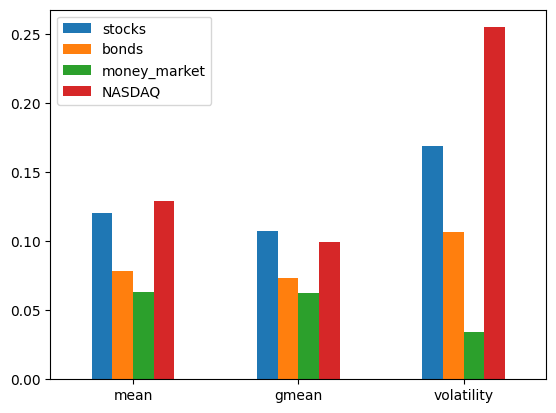

In [361]:
model = MarkowitzModel(data2)
result = model.solve()
portfolios_to_dataframe(result, labels2)

ax = model.get_mean_gmean_volatility().plot.bar(rot=0)
plt.show()

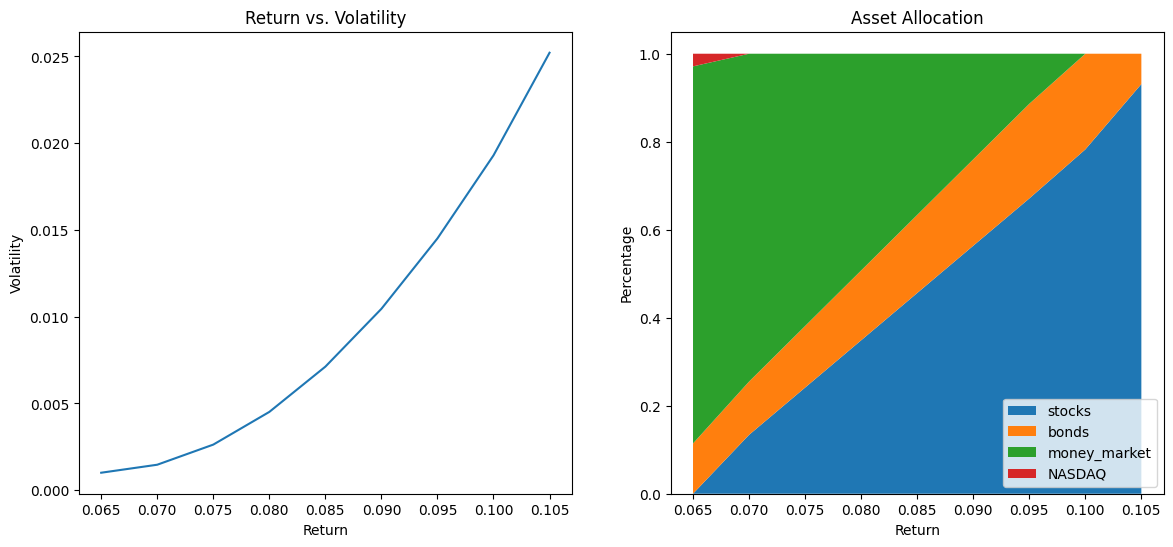

,return,volatility,stocks,bonds,money_market,NASDAQ
0,0.065,0.001006,8.799327e-08,0.114191,8.570560e-01,2.875247e-02
1,0.070,0.001467,1.338142e-01,0.121077,7.451083e-01,1.430952e-07
2,0.075,0.002627,2.412473e-01,0.139894,6.188591e-01,4.517902e-09
3,0.080,0.004511,3.486794e-01,0.158711,4.926091e-01,8.652885e-07
4,0.085,0.007121,4.561132e-01,0.177526,3.663605e-01,9.379729e-08
5,0.090,0.010455,5.635459e-01,0.196343,2.401111e-01,4.597395e-07
6,0.095,0.014513,6.709793e-01,0.215159,1.138621e-01,5.929833e-09
7,0.100,0.019300,7.824503e-01,0.217547,3.116433e-06,6.302672e-10
8,0.105,0.025218,9.310274e-01,0.068972,9.755138e-07,1.182574e-07


In [362]:
model = MarkowitzModel(data2)
portfolios = model.solve(targets=np.arange(0.065, 0.110, 0.005))
df = portfolios_to_dataframe(portfolios, labels2)
plot_portfolio(df, labels2)

df

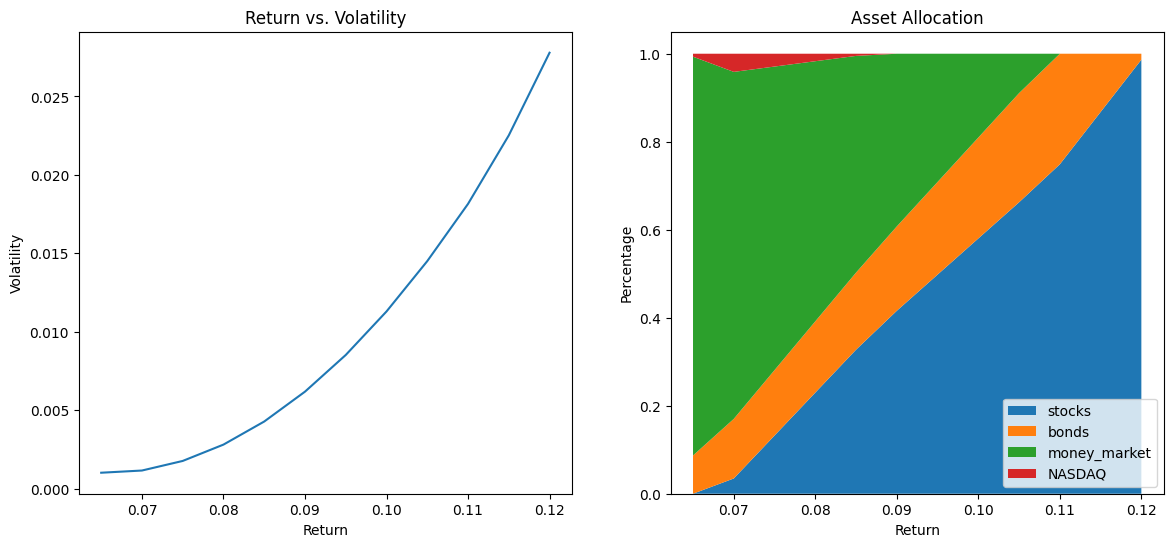

,return,volatility,stocks,bonds,money_market,NASDAQ
0,0.065,0.001022,4.936353e-07,0.086893,9.063759e-01,6.731035e-03
1,0.070,0.001162,3.466638e-02,0.135425,7.886428e-01,4.126616e-02
2,0.075,0.001773,1.322312e-01,0.148697,6.899268e-01,2.914490e-02
3,0.080,0.002814,2.298017e-01,0.161967,5.912117e-01,1.701926e-02
4,0.085,0.004285,3.273070e-01,0.175261,4.924870e-01,4.944914e-03
5,0.090,0.006188,4.157639e-01,0.191796,3.924322e-01,7.614164e-06
6,0.095,0.008525,4.979708e-01,0.210571,2.914585e-01,5.041505e-08
7,0.100,0.011298,5.801678e-01,0.229349,1.904834e-01,3.129694e-07
8,0.105,0.014507,6.623654e-01,0.248126,8.950834e-02,2.568962e-08
9,0.110,0.018153,7.487256e-01,0.251274,7.238500e-08,3.074854e-10


In [363]:
model = MarkowitzModel(data2)
portfolios = model.solve(targets=np.arange(0.065, 0.125, 0.005), use_geometric_mean=False)
df = portfolios_to_dataframe(portfolios, labels2)
plot_portfolio(df, labels2)

df